# Experiment Example

In [1]:
import sys, os
from pyprojroot import here
import logging
import pathlib

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()

PATH = pathlib.Path(str(here()))
# root = here(project_files=[".here"])
sys.path.append(str(here()))


import argparse
import numpy as np

# drought tools
from src.data.drought.loader import DataLoader
from src.features.drought.build_features import (
    get_cali_geometry,
    mask_datacube,
    remove_climatology,
    get_density_cubes,
    get_common_elements_many,
)
import pandas as pd
from src.models.similarity import rv_coefficient, rbig_it_measures
from src.rbig.rbig import RBIGMI, RBIG
from sklearn.preprocessing import StandardScaler
from src.models.train_models import get_similarity_scores
from src.models.similarity import univariate_stats
from tqdm import tqdm
from src.features.utils import subset_indices
from scipy import stats
from src.experiments.utils import dict_product
import itertools

RES_PATH = PATH.joinpath("data/drought/results/")
# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()

# Utilities
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Notebook Specifics
%load_ext autoreload
%autoreload 2

In [2]:
# Load Data
region = 'conus'
sampling = '14D'

drought_cube = DataLoader().load_data(region, sampling)

# Subset california
cali_geoms = get_cali_geometry()

drought_cube = mask_datacube(drought_cube, cali_geoms)

# interpolate
# interpolation arguments
interp_dim = 'time'
method = 'linear'

# do interpolation
drought_cube = drought_cube.interpolate_na(
    dim=interp_dim, 
    method=method
)

# remove climatology
drought_cube, _ = remove_climatology(drought_cube)


# drought years
drought_years = {
    "2010": False,
    "2011": False,
    "2012": True,
    "2013": False,
    "2014": True,
    "2015": True,
}

# MI elements
common_vars = [
    ('VOD', 'NDVI'),
    ('VOD', 'LST'),
    ('VOD', 'SM'),
    ('NDVI', 'LST'),
    ('NDVI', 'SM'),
    ('LST', 'SM')
]

variables = [
    'VOD', 'NDVI', 'SM', 'LST'
]

## Combined Measures

In [3]:
parameters = {}
parameters["cubes"] = list(drought_cube.groupby("time.year"))
parameters["temporal"] = np.arange(1, 12 + 1)
parameters["spatial"] = np.arange(1, 1 + 1)
parameters = list(dict_product(parameters))
logging.info(f"# of params: {len(parameters)}")

INFO:root:# of params: 72


In [4]:
iparams = parameters[0]



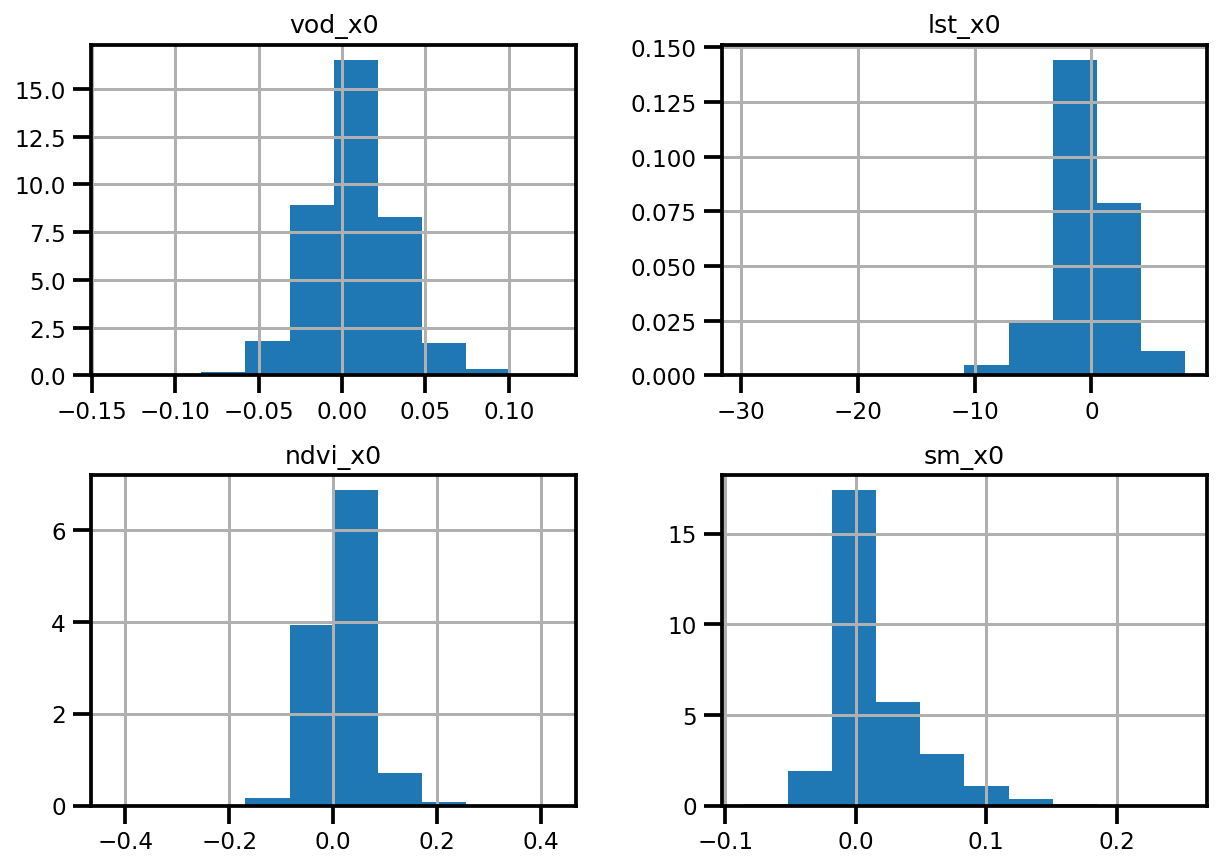

In [5]:
vod_df, lst_df, ndvi_df, sm_df = get_density_cubes(
            iparams["cubes"][1], iparams["spatial"], iparams["temporal"]
        )

vod_df.columns = vod_df.columns.str.replace(r'var', 'vod')
lst_df.columns = lst_df.columns.str.replace(r'var', 'lst')
ndvi_df.columns = ndvi_df.columns.str.replace(r'var', 'ndvi')
sm_df.columns = sm_df.columns.str.replace(r'var', 'sm')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
vod_df.hist(ax=ax[0,0], density=True, label='VOD')
lst_df.hist(ax=ax[0,1], density=True, label='LST')
ndvi_df.hist(ax=ax[1,0], density=True, label='NDVI')
sm_df.hist(ax=ax[1,1], density=True, label='SM')
plt.show()

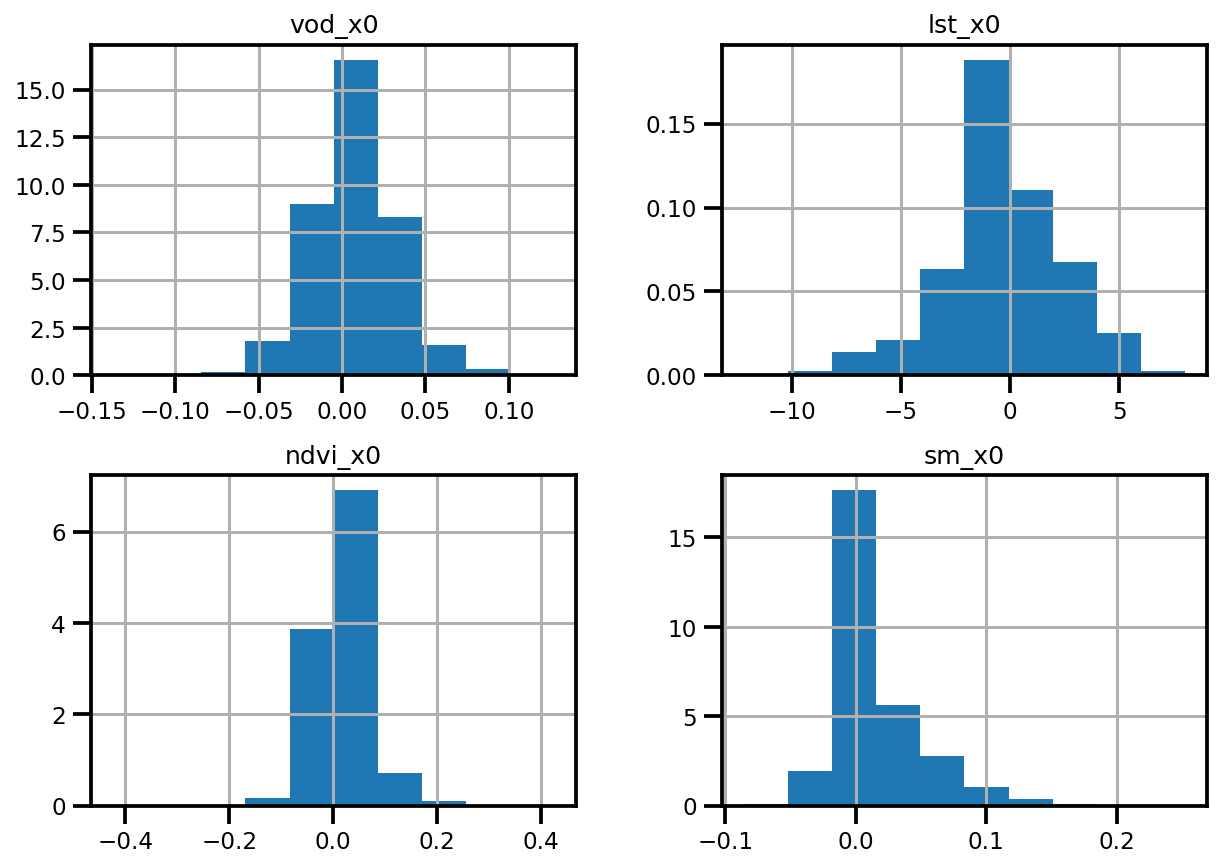

In [6]:
# get common elements
dfs = get_common_elements_many([vod_df, lst_df, ndvi_df, sm_df])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
dfs[0].hist(ax=ax[0,0], density=True, label='VOD')
dfs[1].hist(ax=ax[0,1], density=True, label='LST')
dfs[2].hist(ax=ax[1,0], density=True, label='NDVI')
dfs[3].hist(ax=ax[1,1], density=True, label='SM')
plt.show()

In [7]:
dfs_ = pd.concat(dfs, axis=1)

In [8]:
# dfs_ = pd.concat(dfs, axis=1)

# grids = sns.PairGrid(dfs_)
# grids.map_diag(sns.distplot)
# grids.map_upper(sns.kdeplot)
# grids.map_lower(plt.scatter)

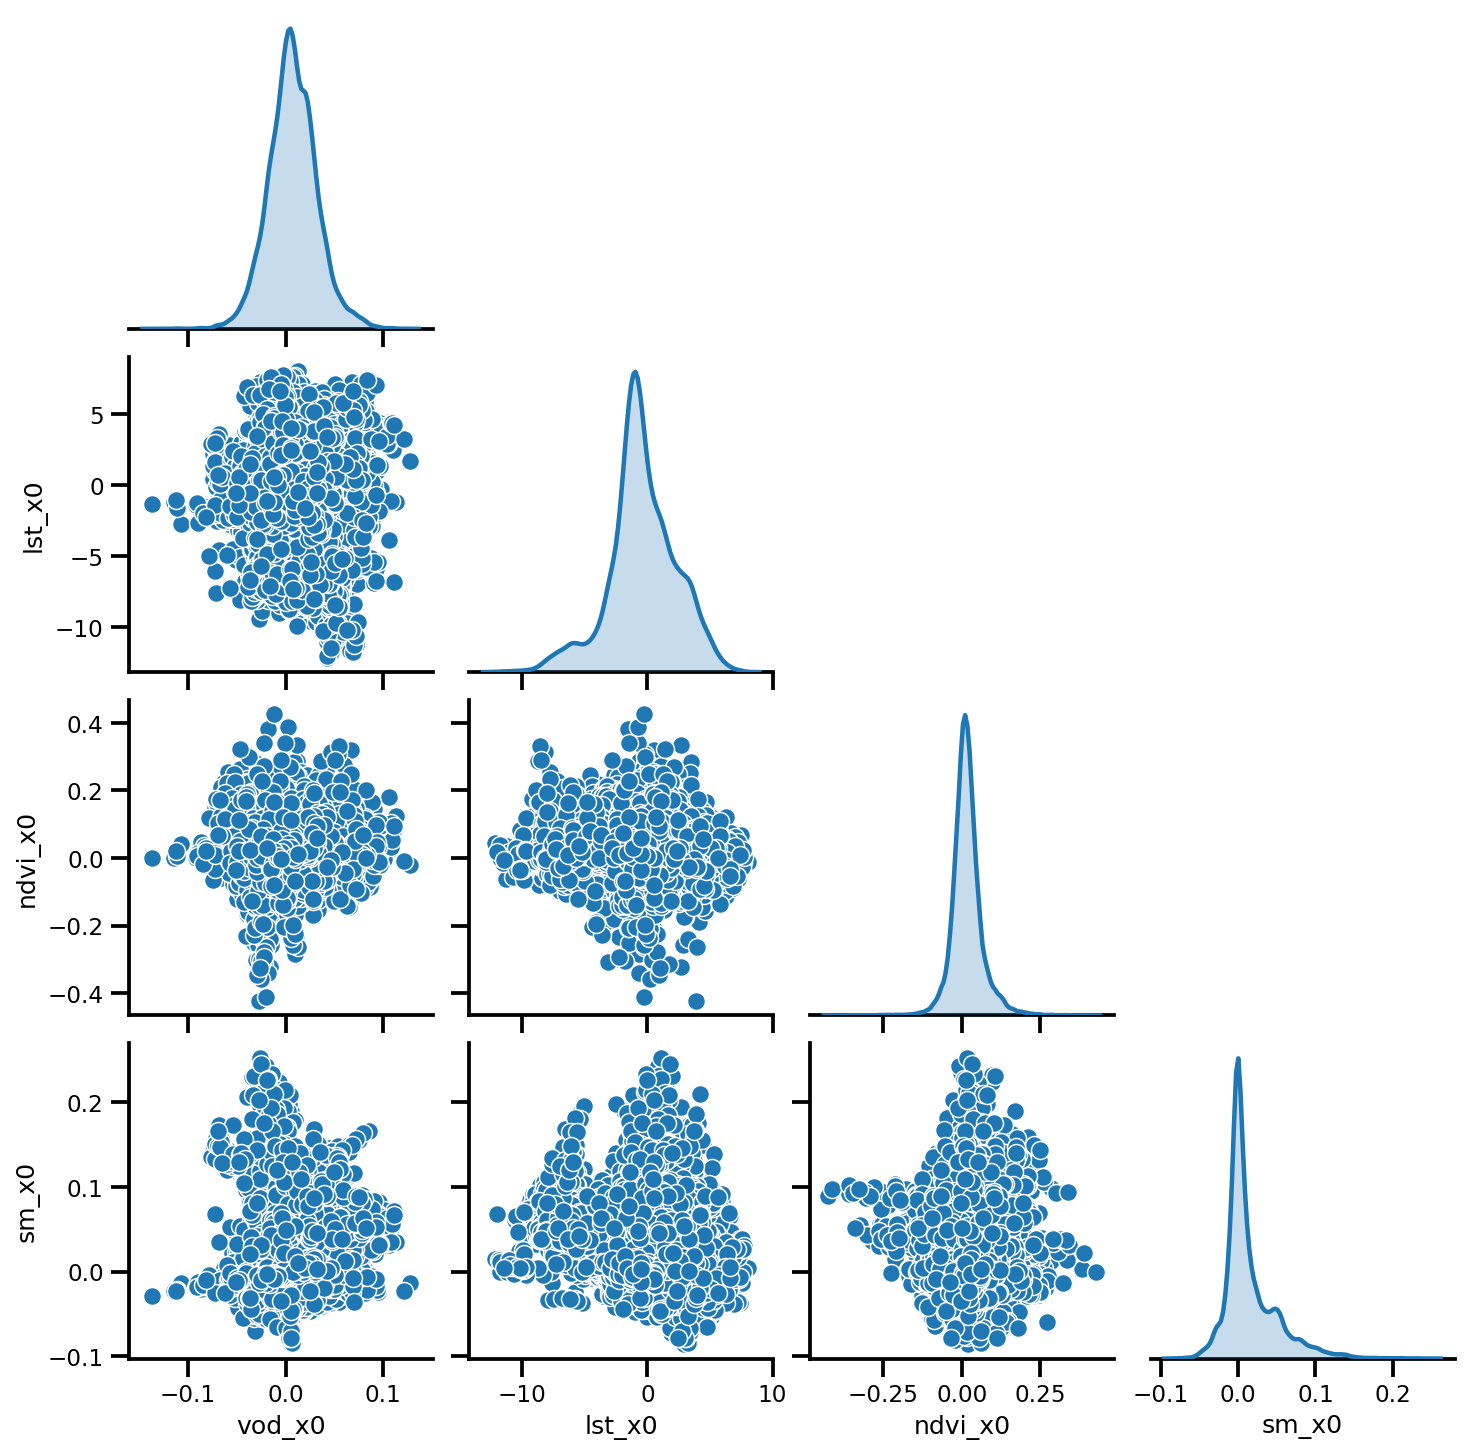

In [9]:


g = sns.pairplot(dfs_, corner=True, diag_kind="kde")

### SMADI Variables

In [10]:
var_set1 = pd.concat([dfs[3], dfs[1], dfs[2]], axis=1)
var_set2 = pd.concat(dfs, axis=1)

In [11]:
# subset indeices
idx = subset_indices(var_set1, subsample=1_000)

# standardize data
X_norm = StandardScaler().fit_transform(var_set1.iloc[idx, :].values)
Y_norm = StandardScaler().fit_transform(var_set2.iloc[idx, :].values)

In [12]:
rv_stats = rv_coefficient(X_norm, Y_norm)
rv_stats

{'rv_coef': 0.8754367792737628,
 'x_norm': 1798.3798926722434,
 'y_norm': 2068.800960128259,
 'xy_norm': 3257053.8254977157}

### Model II - Gaussianization

#### Entropy

In [13]:

rbig_results = {}

In [14]:
H_rbig_model = RBIG(
    n_layers=10000,
    rotation_type='PCA',
    zero_tolerance=60,
    pdf_extension=10,
    verbose=1,
    random_state=123
)
rbig_results["rbig_H_x"] = H_rbig_model.fit(X_norm).entropy(correction=True)
rbig_results["rbig_H_y"] = H_rbig_model.fit(Y_norm).entropy(correction=True)
rbig_results

{'rbig_H_x': 5.111466563198376, 'rbig_H_y': 6.937688552994498}

#### Mutual Information

In [15]:
rbig_model_X = RBIG(
    n_layers=10000,
    rotation_type='PCA',
    zero_tolerance=60,
    pdf_extension=10,
    verbose=1,
    random_state=123
)

X_trans = rbig_model_X.fit_transform(X_norm)


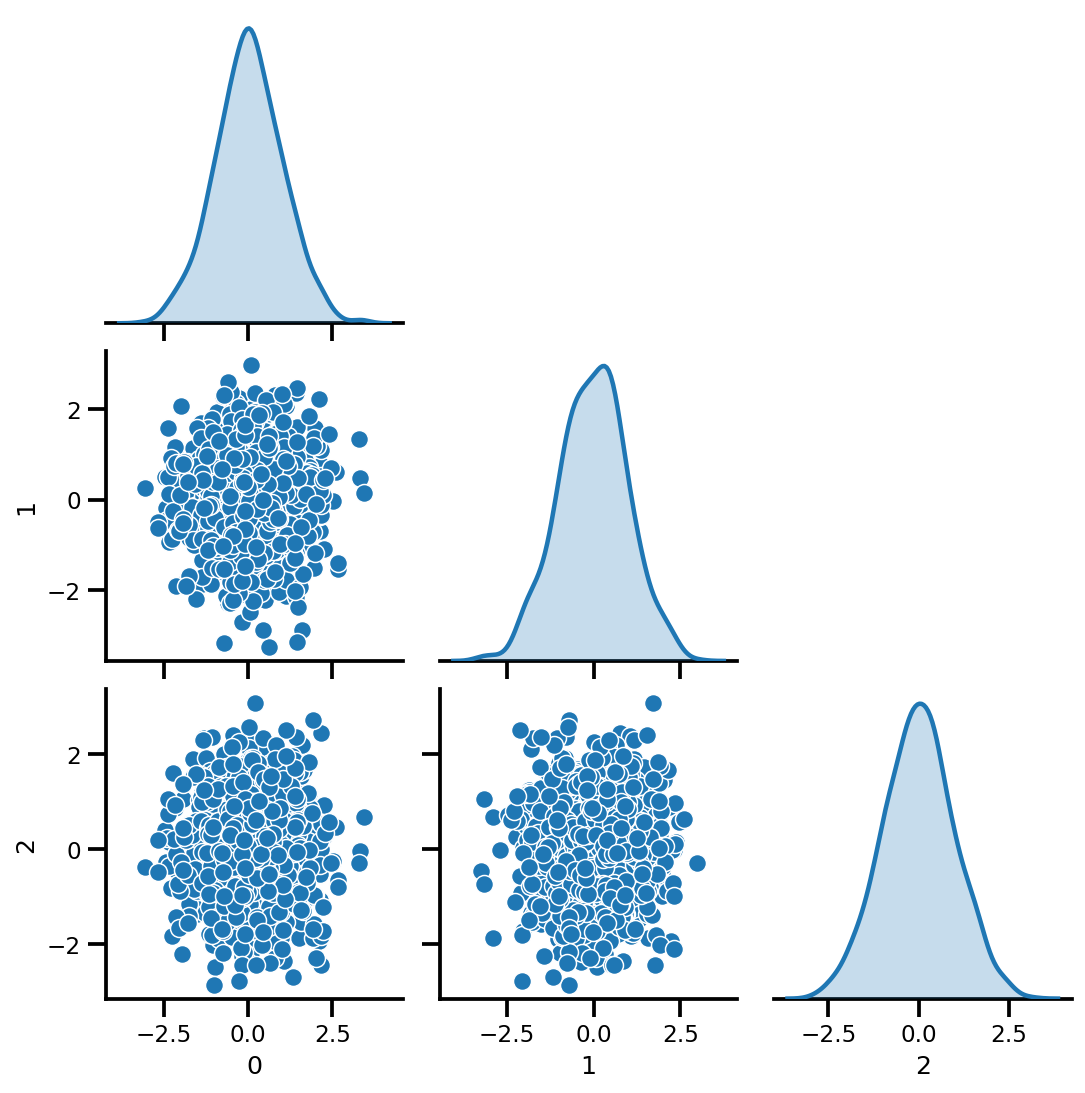

In [16]:
g = sns.pairplot(pd.DataFrame(data=X_trans), corner=True, diag_kind="kde")

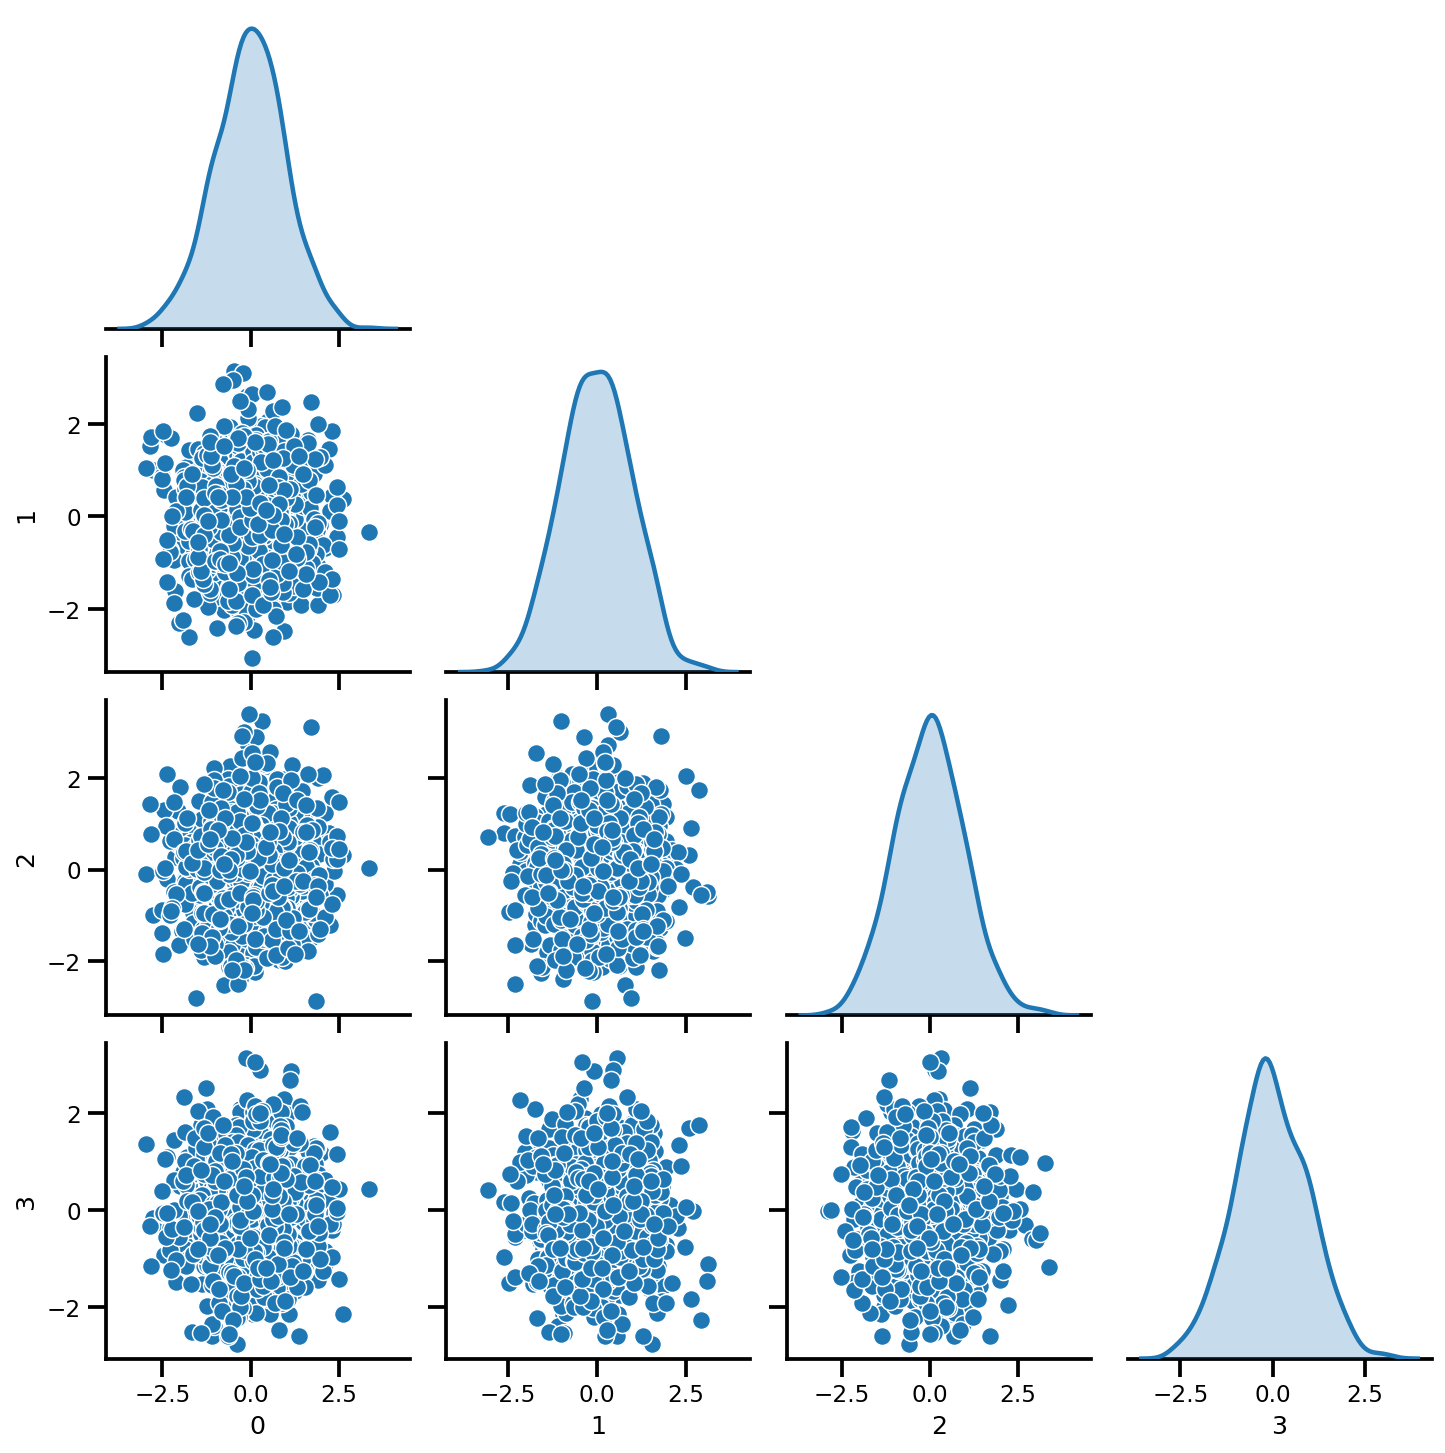

In [17]:
rbig_model_Y = RBIG(
    n_layers=10000,
    rotation_type='PCA',
    zero_tolerance=60,
    pdf_extension=10,
    verbose=1,
    random_state=123
)

Y_trans = rbig_model_Y.fit_transform(Y_norm)

g = sns.pairplot(pd.DataFrame(data=Y_trans), corner=True, diag_kind="kde")

In [37]:
XY_norm = np.hstack([X_trans+10*np.random.randn(*X_trans.shape), Y_trans])
# g = sns.pairplot(pd.DataFrame(data=XY_norm), corner=True, diag_kind="kde")

rbig_model_XY = RBIG(
    n_layers=10000,
    rotation_type='PCA',
    zero_tolerance=60,
    pdf_extension=10,
    verbose=1,
    random_state=123
)

XY_trans = rbig_model_XY.fit_transform(XY_norm)

In [38]:
rbig_model_XY.residual_info.sum()

0.10468701520717794

In [39]:
I_rbig_model = RBIGMI(
    n_layers=10000,
    rotation_type='PCA',
    zero_tolerance=60,
    pdf_extension=50,
    verbose=1,
    random_state=123
)

rbig_results["rbig_I_xy"] = I_rbig_model.fit(X_norm, Y_norm).mutual_information()
rbig_results

PDF Extension: 50%
(1000, 3) (1000, 4)


{'rbig_H_x': 5.111466563198376,
 'rbig_H_y': 6.937688552994498,
 'rbig_I_xy': 9.285946984720816}

In [30]:
rbig_results

{'rbig_H_x': 5.111466563198376,
 'rbig_H_y': 6.937688552994498,
 'rbig_I_xy': 9.285946984720816}

In [31]:
rbig_it_measures(X_norm, Y_norm)

{'rbig_H_x': 5.144240181862336,
 'rbig_H_y': 6.878839448052048,
 'rbig_H_time': 1.0020966529846191,
 'rbig_I_xy': 9.8876160452143,
 'rbig_I_time': 3.7032034397125244,
 'rbig_I_xx': 161.3502976847723,
 'rbig_Ixx_time': 3.3461267948150635}

## Experiment I - Individual Measurements

In this part, we will look at the standard individual measurements such as 

* Entropy, H
* Total Correlation, TC

In [81]:
time_steps = range(1,12)
spatial = 1
results_df_single = pd.DataFrame()


with tqdm(drought_cube.groupby('time.year')) as years_bar:
    # group datacube by years
    for iyear, icube in years_bar:

        # Loop through time steps
        for itime_step in time_steps:

            # extract density cubes
            vod_df, lst_df, ndvi_df, sm_df = get_density_cubes(icube, spatial, itime_step)


            # get common elements
            dfs = get_common_elements_many([vod_df, lst_df, ndvi_df, sm_df])
            vod_df, lst_df, ndvi_df, sm_df = dfs[0], dfs[1], dfs[2], dfs[3]


            variables = {
                'VOD': vod_df,
                'NDVI': ndvi_df,
                'SM': sm_df,
                'LST': lst_df
            }



            # do calculations for H, TC
            for iname, idata in variables.items():
                


                # normalize data
                X_norm = StandardScaler().fit_transform(idata)

                # entropy, total correlation
                tc, h, t_ = run_rbig_models(X_norm, measure="t", random_state=123)

                # get H and TC
                results_df_single = results_df_single.append({
                    'year': iyear,
                    'drought': drought_years[iyear],
                    'samples': X_norm.shape[0],
                    'dimensions': X_norm.shape[1],
                    'temporal': itime_step,
                    'variable': iname,
                    'tc': tc,
                    'h': h,
                    'time': t_,

                }, ignore_index=True)
            
                postfix = dict(
                    Dims=f"{itime_step}",
                    Variable=f"{iname}",
                )
                years_bar.set_postfix(postfix)
            # do calculations for 
            break
        break
    
    

  0%|          | 0/6 [00:03<?, ?it/s, Dims=1, Variable=LST] 


## Experiment II - Comparing Measurements

In this experiment, we will look at different combinations of variables. The following measurements will be calculated and compared:

* Pearson Correlation
* Spearman Correlation
* Mutual Information
* HSIC...

In [18]:
time_steps = range(1,12)
spatial = 1
results_df_single = pd.DataFrame()


with tqdm(drought_cube.groupby('time.year')) as years_bar:
    # group datacube by years
    for iyear, icube in years_bar:

        # Loop through time steps
        for itime_step in time_steps:

            # extract density cubes
            vod_df, lst_df, ndvi_df, sm_df = get_density_cubes(icube, spatial, itime_step)


            # get common elements
            dfs = get_common_elements_many([vod_df, lst_df, ndvi_df, sm_df])
            vod_df, lst_df, ndvi_df, sm_df = dfs[0], dfs[1], dfs[2], dfs[3]


            variables = {
                'VOD': vod_df,
                'NDVI': ndvi_df,
                'SM': sm_df,
                'LST': lst_df
            }



            # do calculations for H, TC
            for (ivar1, ivar2) in common_vars:
#             for iname, idata in variables.items():

                # Pearson coeffcient
                pears = stats.pearsonr(
                    variables[ivar1].values.ravel(), 
                    variables[ivar2].values.ravel()
                )[0]
                
                # Spearman Coefficient
                spears = stats.spearmanr(
                    variables[ivar1].values.ravel(), 
                    variables[ivar2].values.ravel()
                )[0]

                # normalize data
                X_norm = StandardScaler().fit_transform(variables[ivar1])
                Y_norm = StandardScaler().fit_transform(variables[ivar2])

                # entropy, total correlation
                mi, t_ = run_rbig_models(X_norm, Y_norm, measure="mi", random_state=123)

                # get H and TC
                results_df_single = results_df_single.append({
                    'year': iyear,
                    'drought': drought_years[str(iyear)],
                    'samples': X_norm.shape[0],
                    'dimensions': X_norm.shape[1],
                    'temporal': itime_step,
                    'variable1': ivar1,
                    'variable2': ivar2,
                    'pearson': pears,
                    'mi': mi,
                    'time': t_,

                }, ignore_index=True)
            
                postfix = dict(
                    Year=f"{iyear}", 
                    Dims=f"{itime_step}",
                    Variables=f"{ivar1}-{ivar2}",
                    MI=f"{mi:.3f}",
                    Pear=f"{pears:.3f}",
                    Spear=f"{spears:.3f}",
                )
                years_bar.set_postfix(postfix)
            # do calculations for 
            break
        break
    

  0%|          | 0/6 [00:18<?, ?it/s, Year=2010, Dims=1, Variables=LST-SM, MI=0.183, Pear=-0.232, Spear=-0.214]  


In [5]:
results_df_single.head()

dimensions        mi  samples  temporal      time variable1 variable2
0         1.0  0.014735  25779.0       1.0  2.484674       VOD      NDVI
1         1.0  0.024350  25779.0       1.0  2.564911       VOD       LST
2         1.0  0.157174  25779.0       1.0  2.743430       VOD        SM
3         1.0  0.019120  25779.0       1.0  2.564871      NDVI       LST
4         1.0  0.059311  25779.0       1.0  2.583604      NDVI        SM

In [12]:
stats.spearmanr(variables[ivar1].values.ravel(), variables[ivar2].values.ravel())

SpearmanrResult(correlation=0.08307110054436087, pvalue=1.0326962564352802e-40)